## SI671 Final Project
#### Sizhuang He (sizhuang), Yuyuan Ji (jiyuyuan), Yuqing Zhang (zhyuqing)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

### 1. Data Preprocessing

In [ ]:
dataset = pd.read_csv('marketing_campaign.csv', sep = '\t')
dataset = dataset.drop(columns = ['Z_CostContact', 'Z_Revenue'], axis = 1)
dataset.head()

In [ ]:
dataset.info()

In [ ]:
# Identify number of columns by type
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']
discrete_features = [feature for feature in numerical_features if len(dataset[feature].unique())<25]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
categorical_features = [feature for feature in dataset.columns if feature not in numerical_features]
binary_categorical_features = [feature for feature in categorical_features if len(dataset[feature].unique()) <=3]
print("Numerical Features Count {}".format(len(numerical_features)))
print("Discrete features Count {}".format(len(discrete_features)))
print("Continuous features Count {}".format(len(continuous_features)))
print("Categorical features Count {}".format(len(categorical_features)))
print("Binary Categorical features Count {}".format(len(binary_categorical_features)))

In [ ]:
print("Categorical features are: ", categorical_features)

In [ ]:
dataset['Marital_Status'].value_counts()

In [ ]:
# Remove and combine some categories in marital status
dataset['Marital_Status'] = dataset['Marital_Status'].replace('Alone', 'Single')
dataset = dataset[(dataset.Marital_Status != 'Absurd') & (dataset.Marital_Status != 'YOLO')]

In [ ]:
dataset['Marital_Status'].value_counts()

In [ ]:
dataset['Education'].value_counts()

In [ ]:
# Check if there is null data
dataset.isnull().sum()

In [ ]:
# Fill null data with mean values
from sklearn.impute import SimpleImputer
mean_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
dataset.Income = mean_imputer.fit_transform(dataset[["Income"]])

In [ ]:
# Categorize age data into several groups
def getAgeGroup(age):
  ageGroup = ''
  if age <= 18:
    ageGroup = 'Teenager'
  elif age >18 and age<= 30:
    ageGroup = 'Bachelors'
  elif age >30 and age<=50:
    ageGroup  = 'Adults'
  elif age >50 and age<=70:
    ageGroup = 'Seniors'
  elif age>=70 and age<100:
    ageGroup = 'Retired'
  else:
    ageGroup = 'Expired'
  return ageGroup

In [ ]:
dataset['Age'] = dataset.apply(lambda row: 2023- int(row.Year_Birth), axis = 1)
dataset['AgeGroup'] = dataset.apply(lambda row: getAgeGroup(row.Age), axis = 1)

In [ ]:
# add a new column `accept_offer` to represent whether a customer has ever accepted an offer
# used as labels for classification problem

def accept_offer(record):
    accept = 0
    if 1 in record:
        accept = 1
    return accept

dataset['accept_offer'] = dataset.apply(lambda row:
                                        accept_offer([row.AcceptedCmp1,
                                                      row.AcceptedCmp2,
                                                      row.AcceptedCmp3,
                                                      row.AcceptedCmp4,
                                                      row.AcceptedCmp5,
                                                      row.Response]), 
                                        axis = 1)

In [ ]:
dataset.head()

In [ ]:
dataset.to_csv("preprocessed.csv", index = False)

### 2. Exploratory Data Analysis

#### a. Overview

In [ ]:
dataset = pd.read_csv('preprocessed.csv', index_col = False)
dataset.head()

In [ ]:
dataset.columns

Here are descriptions of each column in this dataframe:

**People**
|Column Name|Description|
|:-|:-|
|`ID`|Customer's unique identifier|
|`Year_Birth`|Customer's birth year|
|`Education`|Customer's education level|
|`Marital_Status`|Customer's marital status|
|`Income`|Customer's yearly household income|
|`Kidhome`|Number of children in customer's household|
|`Teenhome`|Number of teenagers in customer's household|
|`Dt_Customer`|Date of customer's enrollment with the company|
|`Recency`|Number of days since customer's last purchase|
|`Complain`|1 if the customer complained in the last 2 years, 0 otherwise|
|`Age`|Customer's age|
|`Agegroup`|Customer's age group|

**Products**
|Column Name|Description|
|:-|:-|
|`MntWines`|Amount spent on wine in last 2 years|
|`MntFruits`|Amount spent on fruits in last 2 years|
|`MntMeatProducts`|Amount spent on meat in last 2 years|
|`MntFishProducts`|Amount spent on fish in last 2 years|
|`MntSweetProducts`|Amount spent on sweets in last 2 years|
|`MntGoldProds`|Amount spent on gold in last 2 years|

**Promotions**
|Column Name|Description|
|:-|:-|
|`NumDealsPurchases`|Number of purchases made with a discount|
|`AcceptedCmp[number]`|1 if customer accepted the offer in the [number] campaign, 0 otherwise|
|`Response`|1 if customer accepted the offer in the last campaign, 0 otherwise|
|`accept_offer`|1 if customer has ever accepted an offer in any campaign, 0 otherwise|

**Channels**
|Column Name|Description|
|:-|:-|
|`NumWebPurchases`|Number of purchases made through the company’s website|
|`NumCatalogPurchases`|Number of purchases made using a catalogue|
|`NumStorePurchases`|Number of purchases made directly in stores|
|`NumWebVisitsMonth`|Number of visits to company’s website in the last month|


In [ ]:
dataset[['Year_Birth', 'Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain']].describe()

Here is a numerical overview of **People**:     
The mean of age is 54.   
The mean of yearly household income is 52232.51.    
The mean of days since customer's last purchase is 49.1.    
The mean of complaint rate is quite low, only 0.94%.   

In [ ]:
dataset[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
       'MntSweetProducts', 'MntGoldProds']].describe()

Here is a numerical overview of **Products**:     
The mean amount spent on wine in last 2 years is 303.9.  
The mean amount spent on fruits in last 2 years is 26.3.  
The mean amount spent on meat in last 2 years is 166.9.   
The mean amount spent on fish in last 2 years is 37.4.    
The mean amount spent on sweet in last 2 years is 27.1.   
The mean amount spent on gold products in last 2 years is 43.9.   

In [ ]:
dataset[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Response', 'accept_offer']].describe()

Here is a numerical overview of **Promotions**:      
The mean rates for customers to accept the offer in the first 5 campaigns are: 6.4%, 1.3%, 7.3%, 7.5%, 7.2%.     
The mean response rate on the last campaign is 14.8%.
The mean rate for customers to accept at least one offer in the previous campaigns is 27.1%.

In [ ]:
dataset[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
        'NumStorePurchases', 'NumWebVisitsMonth']].describe()

Here is a numerical overview of **Channels**:     
The mean number of purchases made with a discount is 2.3.  
The mean number of purchases made through the company’s website is 4.1.  
The mean number of purchases made using a catalogue is 2.7.  
The mean number of purchases made directly in stores is 5.8.    
The mean number of visits to company’s website in the last month is 5.3.    

#### b. Purchase pattern analysis accross different categorical groups

In [ ]:
dataset.groupby(['Education']).agg(
    {'Income': 'mean' , 'Recency': 'mean', 'Complain': 'mean',
     'MntWines': 'mean', 'MntFruits': 'mean', 
     'MntMeatProducts': 'mean', 'MntFishProducts': 'mean', 
     'MntSweetProducts': 'mean', 'MntGoldProds': 'mean',
     'NumDealsPurchases': 'mean', 'NumWebPurchases': 'mean', 
     'NumCatalogPurchases': 'mean', 'NumStorePurchases': 'mean', 
     'NumWebVisitsMonth': 'mean', 'accept_offer': 'mean'}).transpose()

After calculating the mean of numerical values across different **education** group, we can get:

PhD group has the highest average income, which is around 56137; Basic group has the lowest average income, which is around 20306.

The numbers of days since customer's last purchase are similar across different groups, and Graduation group has the longest recency around 50.

For complain rate, Basic group has 0% complain rate, and 2n Cycle group has the highest 2.0% complain rate.

For products consumption, Basic group has the lowest spent on all the products. PhD group has the highest spent on wine; Graduation group has the highest spent on fruit, meat, and gold products; 2n Cycle group has the highest spent on fish and sweet.

For purchase channels, the average numbers of deal purchases, web purchases, catalogue purchases, and store purchases are all very similar across all the groups except Basic group. Basic group tends to have lower numbers of purchases. The reason might be they have lower average income. PhD group has the highest average number of web purchases, catalogue purchases, and store purchases. This also aligns with their high average income. Though Basic group makes fewer purchases, they have the highest average number of company's website visits in the past month.

For promotions, Basic group has very low accepting rate on campaigns. PhD group has a relatively higher accepting rate on campaigns. 


In [ ]:
dataset.groupby(['Marital_Status']).agg(
    {'Income': 'mean' , 'Recency': 'mean', 'Complain': 'mean',
     'MntWines': 'mean', 'MntFruits': 'mean', 
     'MntMeatProducts': 'mean', 'MntFishProducts': 'mean', 
     'MntSweetProducts': 'mean', 'MntGoldProds': 'mean',
     'NumDealsPurchases': 'mean', 'NumWebPurchases': 'mean', 
     'NumCatalogPurchases': 'mean', 'NumStorePurchases': 'mean', 
     'NumWebVisitsMonth': 'mean', 'accept_offer': 'mean'}).transpose()

After calculating the mean of numerical values across different **marital status** group, we can get:

Widow group has the highest average yearly household income, which is around 56426; Single group has the lowest average yearly household income, which is around 50974.

The numbers of days since customer's last purchase are similar across different groups, and Together group has the longest recency around 50.

For complain rate, Widow group has 0% complain rate, and Single group has the highest 1.2% complain rate.

For products consumption, Widow group has the highest spent on all the products and the amounts are much higher than other groups. Single group has the lowest spent on wine; Together group has the lowest spent on fruit and sweet; Divorced group has the lowest spent on meat and fish. Married group has the lowest spent on gold products.

For purchase channels, Single group tends to have lower numbers of purchases, regardless of the channel. The reason might be they have lower average income. Divorced group has the highest average number of deal purchases. Widow group has the highest average number of web purchases, catalogue purchases, and store purchases. This also aligns with their high average income. But Widow group makes the fewest visits to the company's website compared to other groups.

For promotions, Married and Together groups have lower accepting rate on campaigns compared to other groups. Widow group has a very high accepting rate on campaigns. But the difference between the highest accepting rate and the lowest accepting rate is not as large as that across different education groups.

In [ ]:
dataset.groupby(['AgeGroup']).agg(
    {'Income': 'mean' , 'Recency': 'mean', 'Complain': 'mean',
     'MntWines': 'mean', 'MntFruits': 'mean', 
     'MntMeatProducts': 'mean', 'MntFishProducts': 'mean', 
     'MntSweetProducts': 'mean', 'MntGoldProds': 'mean',
     'NumDealsPurchases': 'mean', 'NumWebPurchases': 'mean', 
     'NumCatalogPurchases': 'mean', 'NumStorePurchases': 'mean', 
     'NumWebVisitsMonth': 'mean', 'accept_offer': 'mean'}).transpose()


After calculating the mean of numerical values across different **age** group, we can get:

Bachelors group has the highest average yearly household income, which is around 62458; Adults group has the lowest average yearly household income, which is around 48078.

The numbers of days since customer's last purchase are similar across different groups except Expired group. The average numbers of days since customer's last purchase of Expired group is the longest, which is 52.7.

For complain rate, Seniors group has the lowest 0.6% complain rate, and Expired group has the highest 33.3% complain rate. But this might be due to the number of people in Expired group is small. Except that, Bachelors group has the highest 7.1% complain rate.

For products consumption, Bachelors group has the highest spent on meat, fish, and sweet, and the amounts are much higher than other groups. Retired group has the highest spent on wine, and Expired group has the highest spent on fruit and gold products. Adults group has the lowest spent on all products except sweet. This might be related to their low income. Expired group has the lowest spent on sweet.

For purchase channels, Expired group tends to have lower numbers of purchases, regardless of the channel. Seniors group has the highest average number of deal purchases. Retired group has the highest average number of web purchases and store purchases. Bachelors group has the highest average number of catalogue purchases. Adults group makes the most visits to the company's website compared to other groups.

For promotions, Bachelors group has higher accepting rate on campaigns while Adults group has very low accepting rate.

#### c. Visualizations

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 2))
ax1.hist(dataset['Age'], bins = 30)
ax1.set_title('Distribution of age')
ax1.set_xlabel('Age')

ax2.hist(dataset['Income'], bins = 30)
ax2.set_title('Distribution of income')
ax2.set_xlabel('Income')
ax2.tick_params(axis = 'x', labelrotation = 30)

ax3.hist(dataset['Recency'], bins = 30)
ax3.set_title('Distribution of days since last purchase')
ax3.set_xlabel('Days since last purchase')

plt.show()

The distributions of age and income are right skewed and have several outliers on the right.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3))

dataset.groupby('Education').size().sort_values(ascending=True).plot(kind = 'barh', ax = ax1)
ax1.set_title('Education counts')

dataset.groupby('Marital_Status').size().sort_values(ascending=True).plot(kind = 'barh', ax = ax2)
ax2.set_title('Marital status counts')

plt.tight_layout()
plt.show()

The majority of the customers are graduated from colleges and in a married or together relation.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
sns.boxplot(data = dataset[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                            'MntSweetProducts', 'MntGoldProds']], ax = ax1)
ax1.tick_params(axis = 'x', labelrotation = 30)
ax1.set_title('Amount spent on different products')

sns.boxplot(data = dataset[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
                            'NumStorePurchases', 'NumWebVisitsMonth']], ax = ax2)
ax2.tick_params(axis = 'x', labelrotation = 30)
ax2.set_title('Number of purchases through different channels')

plt.show()

Comparing to other products, customers spent more on wines and meat.    
The most popular way of purchase is in-store purchase. However, web purchase and catalog purchase have several outliers, meaning some customers are keen on these channels.    

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (10, 12))
age_order = ['Bachelors', 'Adults', 'Seniors', 'Retired', 'Expired']
ax1 = sns.boxplot(x = 'AgeGroup',y = 'MntWines', data = dataset, ax = axes[0, 0], order = age_order)
ax2 = sns.boxplot(x = 'AgeGroup',y = 'MntFruits', data = dataset, ax = axes[0, 1], order = age_order)
ax3 = sns.boxplot(x = 'AgeGroup',y = 'MntMeatProducts', data = dataset, ax = axes[1, 0], order = age_order)
ax4 = sns.boxplot(x = 'AgeGroup',y = 'MntFishProducts', data = dataset, ax = axes[1, 1], order = age_order)
ax5 = sns.boxplot(x = 'AgeGroup',y = 'MntSweetProducts', data = dataset, ax = axes[2, 0], order = age_order)
ax6 = sns.boxplot(x = 'AgeGroup',y = 'MntGoldProds', data = dataset, ax = axes[2, 1], order = age_order)

plt.subplots_adjust(hspace = 0.4) 
plt.show()

Age groups have different product preferences. The bachelors spent more on every categories comparing to other age groups. The adults, seniors, and retired have similar purchase patterns.

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (10, 12))

ax1 = sns.kdeplot(data = dataset, x = 'NumDealsPurchases', hue = 'AgeGroup', fill = True, ax = axes[0, 0])
ax1.set_title("Number of purchases made with a discount")

ax2 = sns.kdeplot(data = dataset, x = 'NumWebPurchases', hue = 'AgeGroup', fill = True, ax = axes[0, 1])
ax2.set_title("Number of purchases made through company website")

ax3 = sns.kdeplot(data = dataset, x = 'NumCatalogPurchases', hue = 'AgeGroup', fill = True, ax = axes[1, 0])
ax3.set_title("Number of purchases made using a catalogue")

ax4 = sns.kdeplot(data = dataset, x = 'NumStorePurchases', hue = 'AgeGroup', fill = True, ax = axes[1, 1])
ax4.set_title("Number of purchases made directly in stores")

ax5 = sns.kdeplot(data = dataset, x = 'NumWebVisitsMonth', hue = 'AgeGroup', fill = True, ax = axes[2, 0])
ax5.set_title("Number of visits to company website in the last month")

axes[2,1].set_visible(False)

plt.subplots_adjust(hspace = 0.4)
plt.show()

We plot the kde plots with different colors representing different age groups. From the 5 kde plots, there is no obvious diffenrence in shopping channels for different age groups.

In [ ]:
fig, axes = plt.subplots(4, 2, figsize = (10, 16))
ax1 = sns.boxplot(x = 'accept_offer',y = 'Income', data = dataset, ax = axes[0, 0])
ax2 = sns.boxplot(x = 'accept_offer',y = 'Age', data = dataset, ax = axes[0, 1])
ax3 = sns.boxplot(x = 'accept_offer',y = 'Recency', data = dataset, ax = axes[1, 0])
ax4 = sns.boxplot(x = 'accept_offer',y = 'NumDealsPurchases', data = dataset, ax = axes[1, 1])
ax5 = sns.boxplot(x = 'accept_offer',y = 'NumWebPurchases', data = dataset, ax = axes[2, 0])
ax6 = sns.boxplot(x = 'accept_offer',y = 'NumCatalogPurchases', data = dataset, ax = axes[2, 1])
ax7 = sns.boxplot(x = 'accept_offer',y = 'NumStorePurchases', data = dataset, ax = axes[3, 0])
ax8 = sns.boxplot(x = 'accept_offer',y = 'NumWebVisitsMonth', data = dataset, ax = axes[3, 1])

plt.subplots_adjust(hspace = 0.4) 
plt.show()

Based on the box plots above, whether to accept offer is mainly related to income, recency, number of web purchases, number of catalog purchases, number of store purchases, and number of web visits. People with higher income, lower recency, more web/catalog/store purchases, and lower web visits are more likely to accept offer.

#### c. Correlation

In [ ]:
dataset_corr = dataset[['Age', 'Income', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']]

In [ ]:
sns.heatmap(dataset_corr.corr(), annot = True, fmt=".1f", cmap = 'crest')
plt.show()

From the heatmap, it can be observed that the strongest positive correlation occurs between the number of catalog purchases and amount spent on meat products. The correlation between household income and the amount spent on wines and meat is also quite strong.

### 3. Preparation for Model Development

In [61]:
dataset = pd.read_csv('preprocessed.csv', index_col = False)
dataset.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,AgeGroup,accept_offer
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,0,1,66,Seniors,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,0,0,69,Seniors,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,0,0,58,Seniors,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,0,0,39,Adults,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,0,0,42,Adults,0


#### a. Encoding categorical attributes

In [62]:
# Transform part of the categorical features into dummies
dataset = pd.get_dummies(dataset, columns=['Education', 'Marital_Status', 'AgeGroup']) 

In [ ]:
dataset.head()

#### b. Combining product categories

In [ ]:
dataset['TotalMntSpent'] = dataset['MntWines'] + dataset['MntFruits'] + dataset['MntMeatProducts'] \
                         + dataset['MntFishProducts'] + dataset['MntSweetProducts'] + dataset['MntGoldProds']

In [ ]:
dataset = dataset.drop(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                        'MntSweetProducts', 'MntGoldProds'], axis = 1)

#### c. Train-test split

In [ ]:
X = dataset.drop(['ID', 'Year_Birth', 'Dt_Customer', 
                  'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
                  'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'accept_offer', 'TotalMntSpent'], axis=1)

# y_amount: regression problem
# y_offer: classification problem
y_amount = dataset['TotalMntSpent']
y_offer = dataset['accept_offer']

In [ ]:
X_train, X_test, y_amount_train, y_amount_test, y_offer_train, \
y_offer_test = train_test_split(X, y_amount, y_offer, test_size = 0.3, random_state = 42)

### 4. Regression

#### a. Feature selection

In [ ]:
# Feature selection based on mutual information
sel_k_cols = SelectKBest(mutual_info_regression, k = 10)
sel_k_cols.fit(X_train, y_amount_train)

selected_indices = sel_k_cols.get_support(indices = True)
selected_features = X_train.columns[selected_indices]
print("Selected Features based on Mutual Information Scores:", selected_features)

Based on the results of F-test and mutual information, we select the following features: 
`Income`, `Kidhome`, `Teenhome`, `Recency`, ``NumDealsPurchases``, `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`, `NumWebVisitsMonth`, `Age`.

In [ ]:
# Keep only the selected columns in the DataFrame
X_train_reg = X_train[selected_features].copy() 
X_test_reg = X_test[selected_features].copy() 

#### b. Scaling

In [ ]:
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

#### c. Model selection

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR(),
    "KNN Regression": KNeighborsRegressor()
}

for name, model in models.items():
    model.fit(X_train_reg_scaled, y_amount_train)
    y_amount_pred = model.predict(X_test_reg_scaled)
    MSE = mean_squared_error(y_amount_test, y_amount_pred)
    R2 = r2_score(y_amount_test, y_amount_pred)
    print(f"{name} - Mean Squared Error: {MSE}")
    print(f"{name} - R^2 Score: {R2}")
    print("\t")

Based on the MSE and R^2 results for all models, I will select the Random Forest Regressor model.

#### d. Parameter selection & prediction

In [ ]:
# Define the parameter grid to search
param_dist = {
    'n_estimators': randint(100, 1000),  
    'max_depth': randint(3, 15),        
    'min_samples_split': randint(2, 20), 
    'min_samples_leaf': randint(1, 10),  
    'max_features': [1.0, 'sqrt'] 
}

# Find best parameters
rf = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_dist, \
                                n_iter = 100, cv = 5, random_state = 42, n_jobs = -1)
random_search.fit(X_train_reg_scaled, y_amount_train)
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

In [ ]:
# Predict using best parameters
y_amount_pred = best_estimator.predict(X_test_reg_scaled)
MSE = mean_squared_error(y_amount_test, y_amount_pred)
R2 = r2_score(y_amount_test, y_amount_pred)

print(f"Best parameters: {best_params}")
print(f"Mean Squared Error: {MSE}")
print(f"R^2 Score: {R2}")

In [ ]:
# Compute feature importance
feature_importance = best_estimator.feature_importances_
feature_names = X_train_reg.columns

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize = (4, 3))
plt.barh(range(len(sorted_importance)), sorted_importance, align = 'center')
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

Based on the results of feature importance, the number of in-store purchases and income are important features in prediction.

In [ ]:
plt.figure(figsize = (4, 3))
sns.regplot(x = y_amount_test, y = y_amount_pred, scatter_kws = {'alpha':0.5})
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('True vs Predicted Values')
plt.show()

### 5. Classification

#### a. Feature selection

In [ ]:
np.random.seed(42)
sel_k_cols = SelectKBest(mutual_info_classif, k = 10)
sel_k_cols.fit(X_train, y_offer_train)

selected_indices = sel_k_cols.get_support(indices = True)
selected_features = X_train.columns[selected_indices]
print("Selected Features based on Mutual Information Scores:", selected_features)

Based on mutual information, we will keep the following variables for the classification problem: `Income`, `Kidhome`, `Recency`, `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`, `NumWebVisitsMonth`, `Education_2n Cycle`, `Marital_Status_Single`, `AgeGroup_Seniors`.

In [ ]:
X_train_clf = X_train[selected_features].copy() 
X_test_clf = X_test[selected_features].copy() 

#### b. Scaling

In [ ]:
num_attribs = list(X_train_clf.select_dtypes(include=[np.number]))

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_attribs)
    ],
    remainder='passthrough'  # Leave other columns unchanged
)

X_train_clf_scaled = preprocessor.fit_transform(X_train_clf)
X_test_clf_scaled = preprocessor.transform(X_test_clf)

#### c. Model selection

In [ ]:
np.random.seed(671)
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Poly SVM",
         "Decision Tree", "Random Forest", "Multi-layer Perceptron", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(),
    SVC(kernel="poly"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

for name, clf in zip(names, classifiers):
    clf.fit(X_train_clf_scaled, y_offer_train)
    cv_scores = cross_val_score(clf, X_train_clf_scaled, y_offer_train, 
                                cv=5, scoring='accuracy')
    accuracy = np.mean(cv_scores)
    print("%s Accuracy: %.2f%%" % (name,accuracy * 100.0))

Random Forest classifier works the best.

#### d. Hyperparameter tuning

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=671)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_clf_scaled, y_offer_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

#### e. Prediction & Model Evaluation

In [ ]:
best_rf = RandomForestClassifier(**best_params, random_state=671)
best_rf.fit(X_train_clf_scaled, y_offer_train)
y_offer_pred = best_rf.predict(X_test_clf_scaled)
accuracy = accuracy_score(y_offer_test, y_offer_pred)
print("Accuracy on Test Set:", accuracy)

In [ ]:
model_performance = classification_report(y_offer_test, y_offer_pred, 
                                          target_names= ['Offer Rejected','Offer Purchased'])
print(model_performance)

In [ ]:
feature_importance = best_rf.feature_importances_
feature_names = X_train_clf.columns

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize = (4, 3))
plt.barh(range(len(sorted_importance)), sorted_importance, align = 'center')
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

According to the feature importance, `income` and `recency` are the most important features for making the decision.

In [ ]:
inverse_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_attribs)
    ],
    remainder='passthrough'  # Leave categorical columns unchanged
)
X_train_clf_scaled = pd.DataFrame(X_train_clf_scaled, columns=X_train_clf.columns)
inverse_transformer.fit(X_train_clf_scaled)
tree = best_rf.estimators_[0]
tree_features_original = inverse_transformer.transform(tree.tree_.feature.reshape(-1, 1))
tree.tree_.feature = tree_features_original.flatten().astype(int)
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_train_clf.columns, filled=True, rounded=True, fontsize=8, max_depth=3)
plt.show()

## Clustering

### Overview

In this section, we are interested in applying clustering methods to customer segmentation

Here, we process the data similar to the way we process it for regression and classification. However, now we use encoders to encoder the categorical features instead of one-hot encoding.

In [112]:
def AcceptOffer(responses):
  Accepted = 0
  if 1 in responses:
    Accepted = 1

  return Accepted

In [135]:
dataset = pd.read_csv('preprocessed.csv', index_col = False)
encoder1 = LabelEncoder()
dataset['Education'] = encoder1.fit_transform(dataset['Education'])
encoder2 = LabelEncoder()
dataset['Marital_Status'] = encoder2.fit_transform(dataset['Marital_Status'])
encoder3 = LabelEncoder()
dataset['AgeGroup'] = encoder3.fit_transform(dataset['AgeGroup'])
dataset["OfferAccepted"] = dataset.apply(lambda row : AcceptOffer([row.AcceptedCmp1,row.AcceptedCmp2,row.AcceptedCmp3,row.AcceptedCmp4,row.AcceptedCmp5,row.Response]), axis = 1)
dataset['TotalMntSpent'] = dataset['MntWines'] + dataset['MntFruits'] + dataset['MntMeatProducts'] \
                         + dataset['MntFishProducts'] + dataset['MntSweetProducts'] + dataset['MntGoldProds']
dataset = dataset.drop(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                        'MntSweetProducts', 'MntGoldProds'], axis = 1)
dataset = dataset.drop(['Dt_Customer', 'ID', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response'], axis=1)

In [115]:
dataset.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age',
       'AgeGroup', 'accept_offer', 'OfferAccepted', 'TotalMntSpent'],
      dtype='object')

Let's look at PCA. The first three principal components explain about half of the variations.

In [117]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(dataset)
pca = PCA()
pca_data = pca.fit_transform(x_scaled)
for variance in pca.explained_variance_ratio_:
  print(round(variance,5), end= ' ')

0.26864 0.16565 0.1052 0.08888 0.05916 0.05702 0.05603 0.04052 0.03799 0.02864 0.02544 0.02182 0.01872 0.01719 0.0091 0.0 0.0 

We want to use K-Means to cluster the data. Here, we use the elbow method to find an optimal value for K. From the plot we find 4 may be an appropriate choice.

In [118]:
inertia = []
n_clusters = [int (i) for i in range(2,10)]

for i in n_clusters:
  model = KMeans(init = 'k-means++', n_clusters = i, random_state =32)
  model.fit(x_scaled)
  inertia.append(model.inertia_)

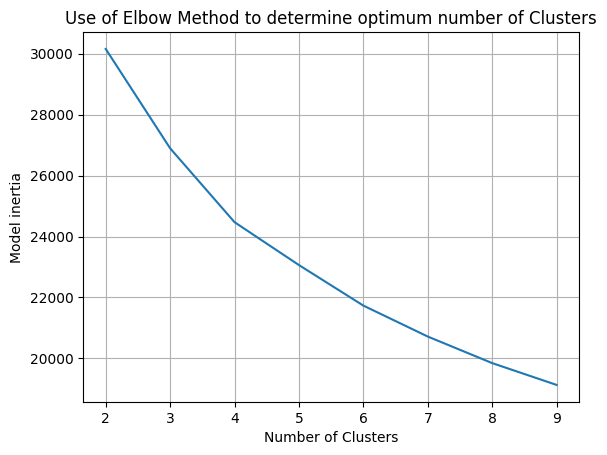

In [119]:
plt.plot(n_clusters, inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Model inertia')
plt.title('Use of Elbow Method to determine optimum number of Clusters')
plt.grid()
plt.show()

### Low dimensional visualization of the dataset

#### PCA 

##### 2D visualization

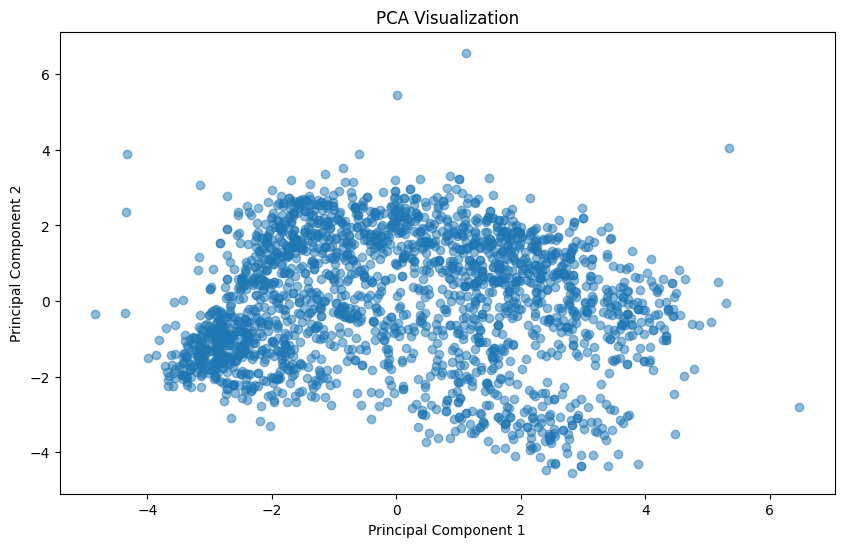

In [121]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(x_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], alpha=0.5)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

##### 3D visualization

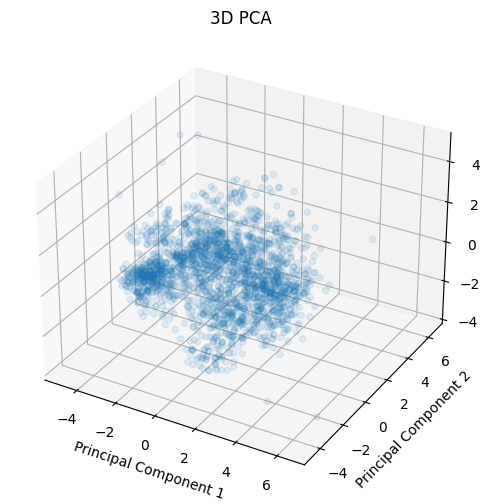

In [124]:
pca_3d = PCA(n_components=3)
pca_3d_results = pca_3d.fit_transform(x_scaled)
principal_df = pd.DataFrame(data=pca_3d_results, columns=['PC1', 'PC2', 'PC3'])
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(principal_df['PC1'], principal_df['PC2'], principal_df['PC3'], alpha=0.1)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA')

plt.show()

#### tSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2236 samples in 0.001s...
[t-SNE] Computed neighbors for 2236 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2236
[t-SNE] Computed conditional probabilities for sample 2000 / 2236
[t-SNE] Computed conditional probabilities for sample 2236 / 2236
[t-SNE] Mean sigma: 1.262589
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.949928
[t-SNE] KL divergence after 300 iterations: 1.599239


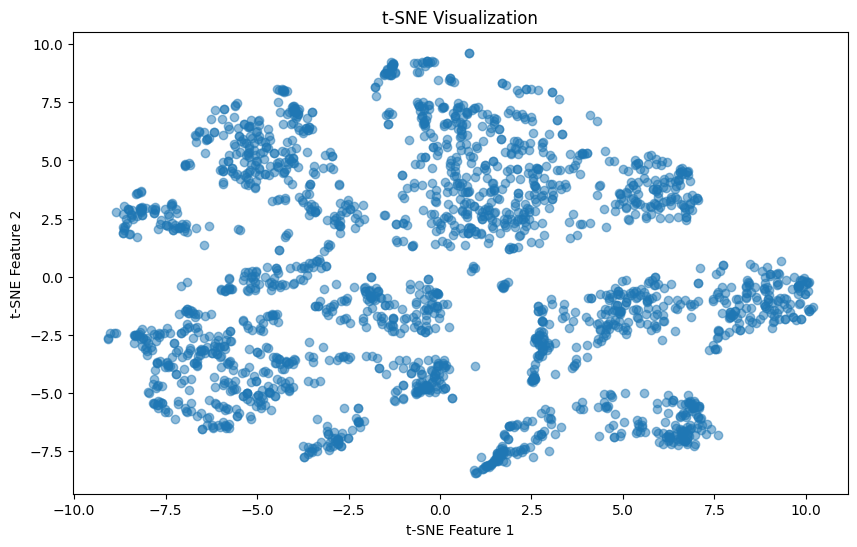

In [125]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(x_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

#### UMAP

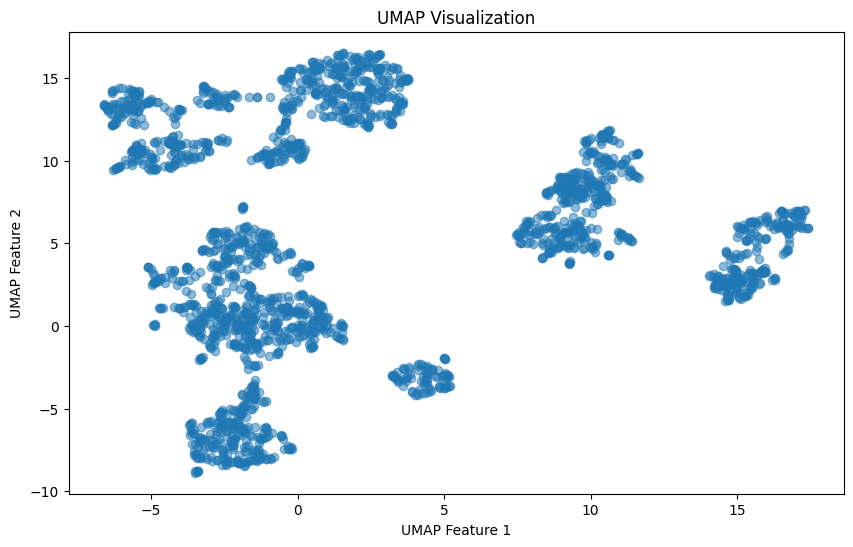

In [126]:
import umap

umap_result = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2).fit_transform(x_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.5)
plt.title('UMAP Visualization')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()

From the visualizations, we see 4 might indeed be a suitable number of clusters.

### K-Means

In [140]:
cluster_model = KMeans(init = 'k-means++', n_clusters = 4,random_state = 0)
cluster_model.fit(x_scaled)
dataset['Customer_Segment'] = cluster_model.labels_

In [131]:
dataset['Education'] = encoder1.inverse_transform(dataset['Education'])
dataset['Marital_Status'] = encoder2.inverse_transform(dataset['Marital_Status'])
dataset['AgeGroup'] = encoder3.inverse_transform(dataset['AgeGroup'])

In [148]:
customers_segment = dataset.groupby('Customer_Segment').agg({'Age':'mean', 'Income': 'mean' , 'NumDealsPurchases': 'mean', 'NumWebPurchases': 'mean', 'NumCatalogPurchases': 'mean', 'NumStorePurchases': 'mean', 'NumWebVisitsMonth': 'mean', 'Education': 'mean', 'Marital_Status': 'mean', 'AgeGroup': 'mean', 'OfferAccepted': 'mean'})
customers_segment = customers_segment.reset_index()
customers_segment

,Customer_Segment,Age,Income,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Education,Marital_Status,AgeGroup,OfferAccepted
0,0,42.791019,33189.837726,2.265976,2.559585,0.623489,3.454231,6.721934,2.027634,1.668394,0.013817,0.157168
1,1,56.433836,68928.134076,2.356784,5.656616,4.626466,8.670017,3.755444,2.492462,1.753769,2.571189,0.000000
2,2,61.223114,39928.484960,2.608347,2.739968,0.807384,3.683788,6.325843,2.526485,1.791332,3.836276,0.126806
3,3,56.270023,72195.505820,1.945080,5.864989,5.308924,7.949657,4.153318,2.546911,1.713959,2.553776,1.000000


Since Education, Marital_Status and OfferAccepted, AgeGroup are categorical, let's plot them in histograms.

In [149]:
dataset['Education'] = encoder1.inverse_transform(dataset['Education'])
dataset['Marital_Status'] = encoder2.inverse_transform(dataset['Marital_Status'])
dataset['AgeGroup'] = encoder3.inverse_transform(dataset['AgeGroup'])

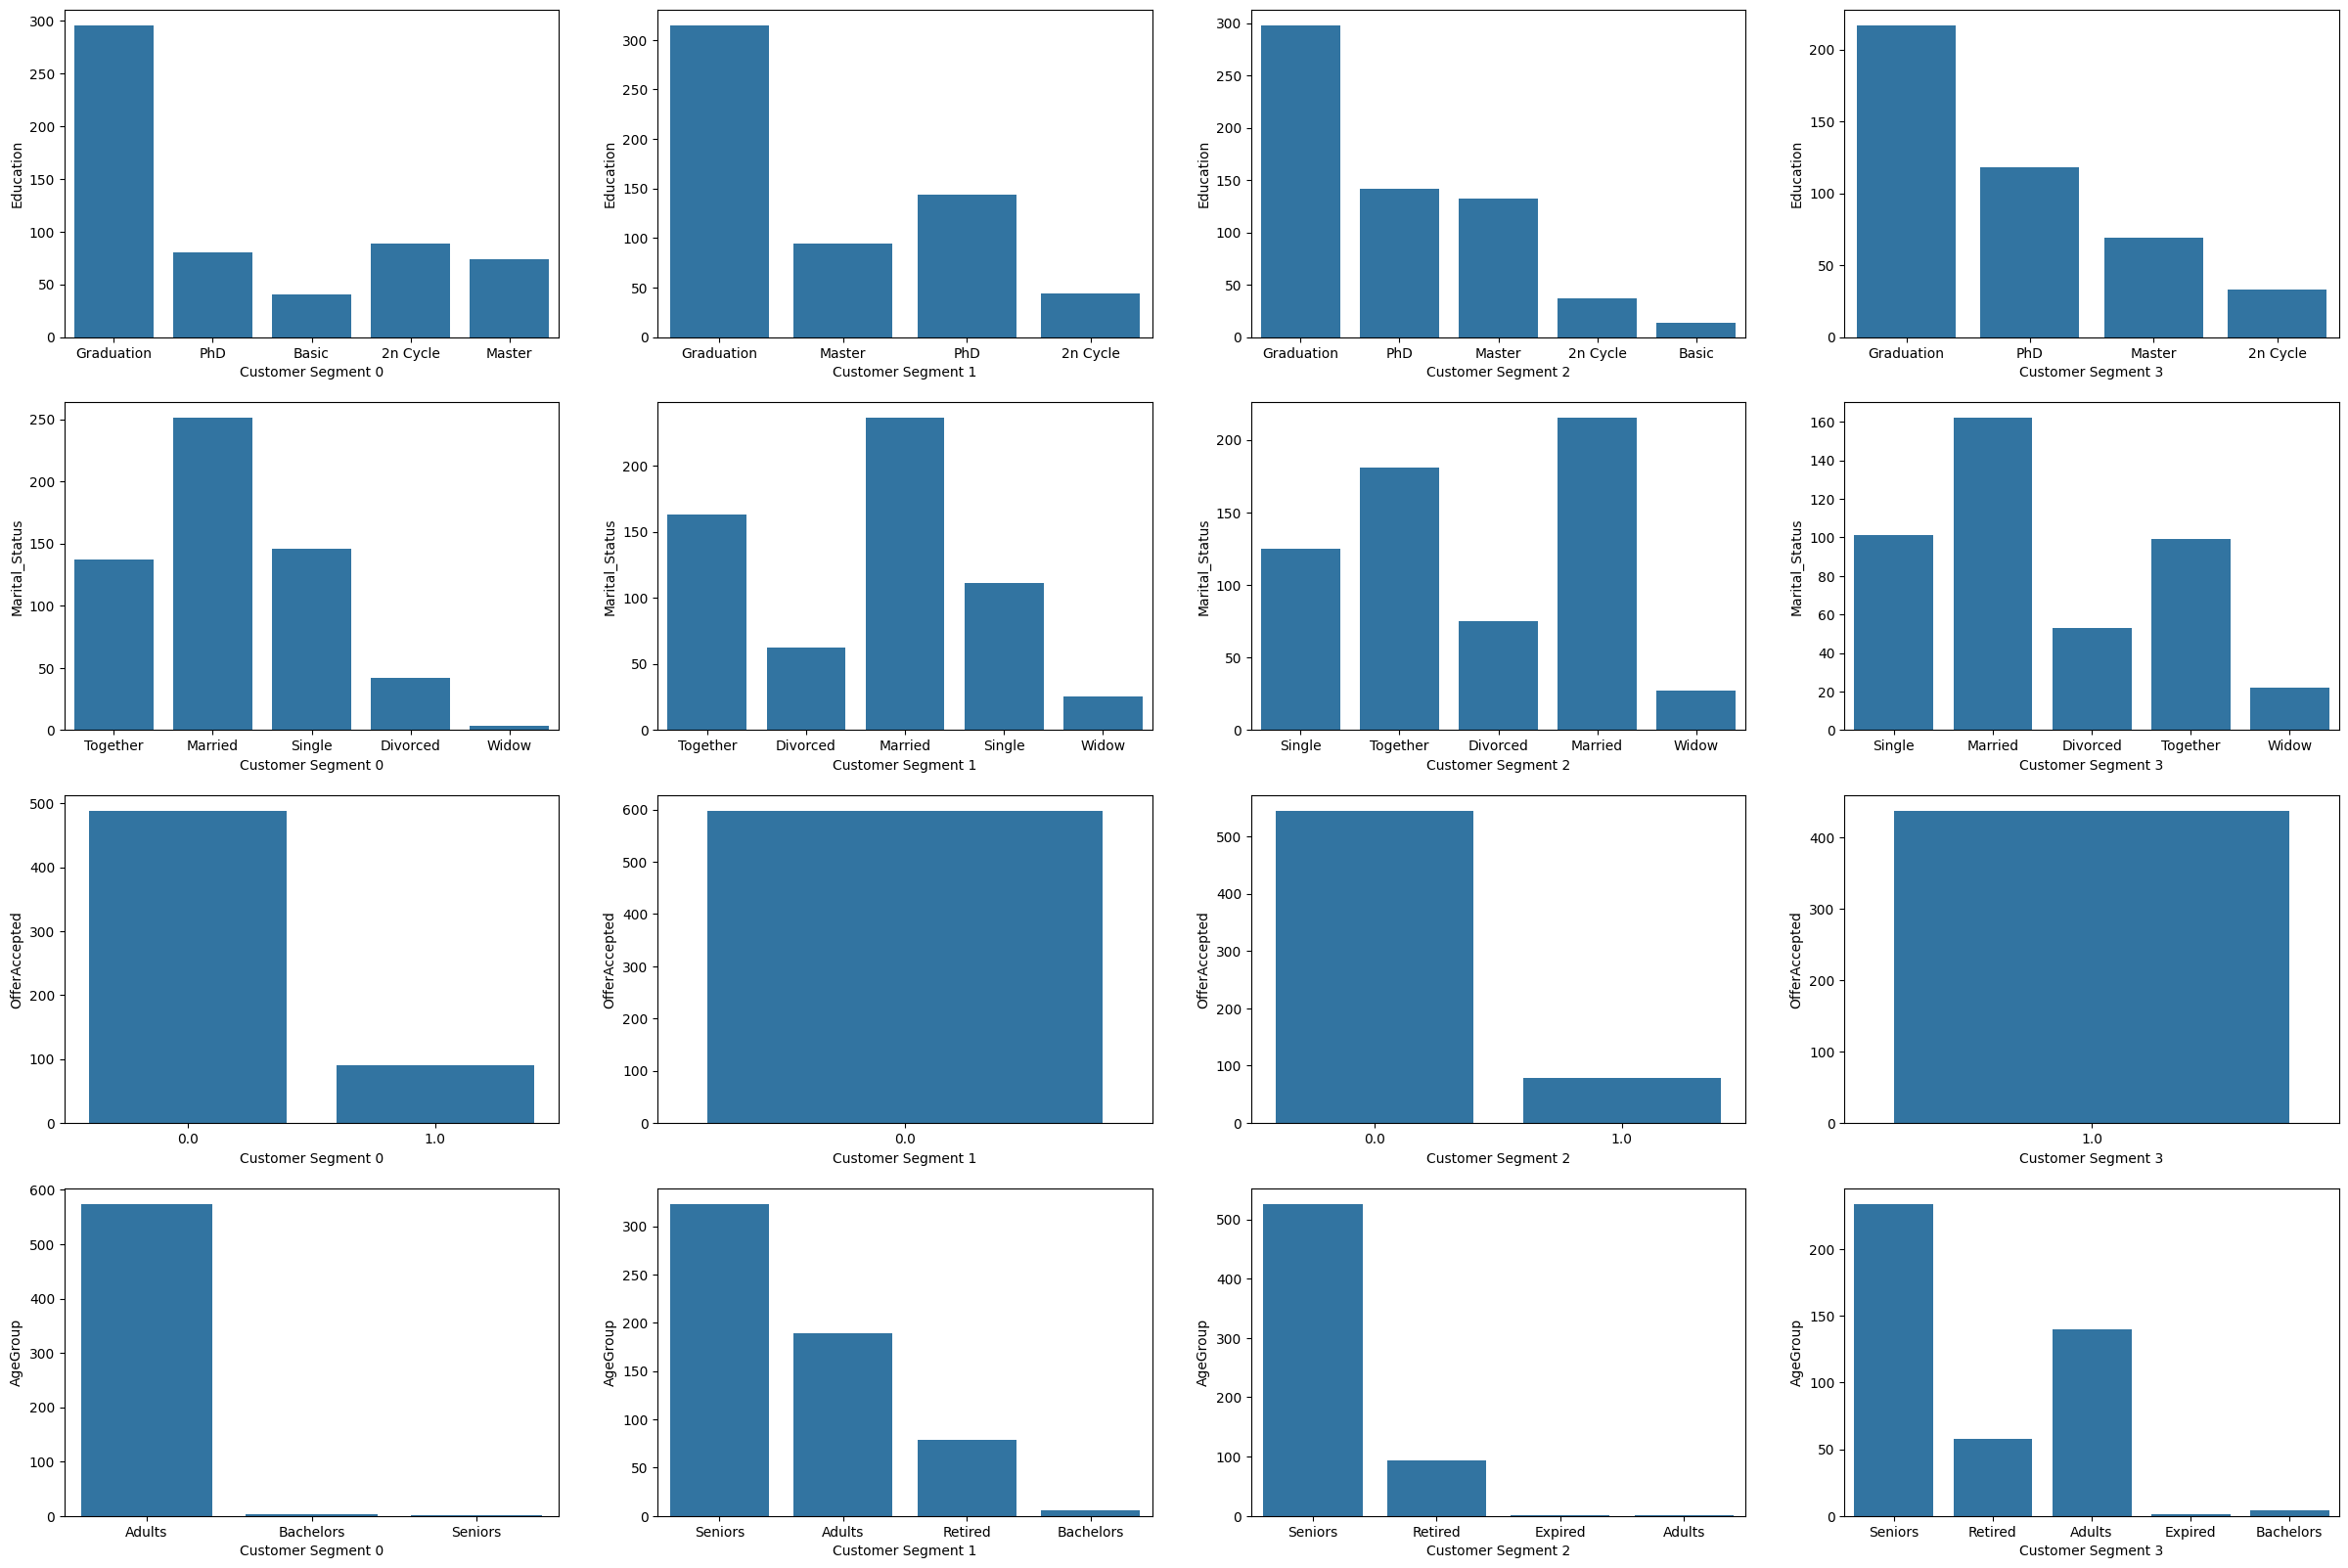

In [151]:
fig, axes = plt.subplots(nrows = 4, ncols =4, figsize = (30,20))
vars = ['Education','Marital_Status', 'OfferAccepted', 'AgeGroup']
row = 0
for var in vars:
  for i in range(4):
    data = dataset.where(dataset['Customer_Segment'] ==  i)
    axes[row][i]=sns.countplot(data, x = var,ax = axes[row][i])
    axes[row][i].set_xlabel(f'Customer Segment {i}')
    axes[row][i].set_ylabel(var)
  row+=1
plt.show()